In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from lib import models, graph, coarsening, utils
import scipy

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
path = "./data"

In [3]:
train_data = np.load(os.path.join(path, "train_apnea_data.npz"))
train_X, train_y = train_data['samples'], train_data['labels']

In [4]:
train_X = np.transpose(train_X)
train_X.shape

(15309, 6000)

In [5]:
train_X = train_X.astype('float32')

In [6]:
test_data = np.load(os.path.join(path, "test_apnea_data.npz"))
test_X, test_y = test_data['samples'], test_data['labels']

In [7]:
test_X = np.transpose(test_X)
test_X.shape

(1701, 6000)

In [8]:
test_X = test_X.astype('float32')

In [9]:
d = train_X.shape[-1]
n = len(train_y) + len(test_y)

In [10]:
n_train = len(train_y)
n_test = len(test_y)

In [11]:
A = np.load(os.path.join(path, "A.npz"))["A"]

In [12]:
A.shape

(6000, 6000)

In [11]:
def dist(a, b):
  return np.square(a - b)

In [12]:
# make adjacency matrix with some more information
sigma_sq = 500.0
A = np.zeros((d,d))
for row_idx in range(d):
  if row_idx % 200 == 0:
    print(row_idx)
  for col_idx in range(d):
    if row_idx == col_idx:
      A[row_idx][col_idx] = 0.0
    else:
      A[row_idx][col_idx] = np.exp((- dist(row_idx, col_idx)) / sigma_sq)

0
200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000
3200
3400
3600
3800
4000
4200
4400
4600
4800
5000
5200
5400
5600
5800


In [12]:
A.shape

(6000, 6000)

In [13]:
with open(os.path.join(path, "A.npz"), "wb") as f:
    np.savez(f, A=A)

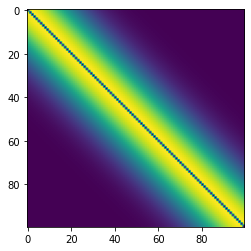

In [14]:
sub = A[:100, :100]
plt.imshow(sub, vmin=0, vmax=1)

In [15]:
A = A.astype('float32')
A = scipy.sparse.csr_matrix(A)

In [16]:
# Coarsening
graphs, perm = coarsening.coarsen(A, levels=6, self_connections=False)

X_train = coarsening.perm_data(train_X, perm)
# X_val = coarsening.perm_data(X_val, perm)
X_test = coarsening.perm_data(test_X, perm)

Layer 0: M_0 = |V| = 6336 nodes (336 added),|E| = 1341894 edges
Layer 1: M_1 = |V| = 3168 nodes (164 added),|E| = 339268 edges
Layer 2: M_2 = |V| = 1584 nodes (78 added),|E| = 86860 edges
Layer 3: M_3 = |V| = 792 nodes (35 added),|E| = 22753 edges
Layer 4: M_4 = |V| = 396 nodes (16 added),|E| = 6139 edges
Layer 5: M_5 = |V| = 198 nodes (5 added),|E| = 1757 edges
Layer 6: M_6 = |V| = 99 nodes (0 added),|E| = 546 edges


In [17]:
L = [graph.laplacian(A, normalized=True) for A in graphs]

Computing laplacian...
Computing laplacian...
Computing laplacian...
Computing laplacian...
Computing laplacian...
Computing laplacian...
Computing laplacian...


In [18]:
# Number of classes.
C = train_y.max() + 1
assert C == np.unique(train_y).size

In [19]:
C

2

In [20]:
params = dict()
params['dir_name']       = 'demo'
params['num_epochs']     = 100
params['batch_size']     = 256
params['eval_frequency'] = 120

# Building blocks.
params['filter']         = 'chebyshev5'
params['brelu']          = 'b1relu'
params['pool']           = 'apool1'

# Architecture.
params['F']              = [32, 32, 32]  # Number of graph convolutional filters.
params['K']              = [20, 20, 20]  # Polynomial orders.
params['p']              = [4, 4, 4]    # Pooling sizes.
params['M']              = [512, C]  # Output dimensionality of fully connected layers.

# Optimization.
params['regularization'] = 5e-4
params['dropout']        = 1
params['learning_rate']  = 1e-3
params['decay_rate']     = 0.95
params['momentum']       = 0.9
params['decay_steps']    = n_train / params['batch_size']

In [ ]:
model = models.cgcnn(L, **params)
accuracy, loss, t_step = model.fit(X_train, train_y, X_test, test_y)

NN architecture
  input: M_0 = 6336
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 6336 * 32 / 4 = 50688
    weights: F_0 * F_1 * K_1 = 1 * 32 * 20 = 640
    biases: F_1 = 32
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 1584 * 32 / 4 = 12672
    weights: F_1 * F_2 * K_2 = 32 * 32 * 20 = 20480
    biases: F_2 = 32
  layer 3: cgconv3
    representation: M_2 * F_3 / p_3 = 396 * 32 / 4 = 3168
    weights: F_2 * F_3 * K_3 = 32 * 32 * 20 = 20480
    biases: F_3 = 32
  layer 4: fc1
    representation: M_4 = 512
    weights: M_3 * M_4 = 3168 * 512 = 1622016
    biases: M_4 = 512
  layer 5: logits (softmax)
    representation: M_5 = 2
    weights: M_4 * M_5 = 512 * 2 = 1024
    biases: M_5 = 2
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use `tf.cast` instead.


2022-06-27 17:29:16.072425: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-27 17:29:16.830602: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14485 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:04:00.0, compute capability: 7.5
2022-06-27 17:29:16.831154: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 14784 MB memory:  -> device: 1, name: Quadro RTX 5000, pci bus id: 0000:65:00.0, compute capability: 7.5
2022-06-27 17:29:17.590293: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2022-06

step 120 / 5980 (epoch 2.01 / 100):
  learning_rate = 9.50e-04, loss_average = 3.78e+00
  validation accuracy: 63.26 (1076 / 1701), f1 (weighted): 54.40, loss: 3.96e+00
  time: 33s (wall 169s)
INFO:tensorflow:/tungstenfs/scratch/gzenke/agarmanv/cnn_graph/lib/../checkpoints/demo/model-120.index
INFO:tensorflow:0
INFO:tensorflow:/tungstenfs/scratch/gzenke/agarmanv/cnn_graph/lib/../checkpoints/demo/model-120.data-00000-of-00001
INFO:tensorflow:13300
INFO:tensorflow:/tungstenfs/scratch/gzenke/agarmanv/cnn_graph/lib/../checkpoints/demo/model-120.meta
INFO:tensorflow:70100
step 240 / 5980 (epoch 4.01 / 100):
  learning_rate = 8.57e-04, loss_average = 3.77e+00
  validation accuracy: 64.20 (1092 / 1701), f1 (weighted): 56.92, loss: 3.95e+00
  time: 63s (wall 337s)
INFO:tensorflow:/tungstenfs/scratch/gzenke/agarmanv/cnn_graph/lib/../checkpoints/demo/model-240.data-00000-of-00001
INFO:tensorflow:13300
INFO:tensorflow:/tungstenfs/scratch/gzenke/agarmanv/cnn_graph/lib/../checkpoints/demo/model-240

INFO:tensorflow:/tungstenfs/scratch/gzenke/agarmanv/cnn_graph/lib/../checkpoints/demo/model-1680.meta
INFO:tensorflow:56800
INFO:tensorflow:/tungstenfs/scratch/gzenke/agarmanv/cnn_graph/lib/../checkpoints/demo/model-1680.data-00000-of-00001
INFO:tensorflow:70100
step 1800 / 5980 (epoch 30.10 / 100):
  learning_rate = 2.15e-04, loss_average = 3.64e+00
  validation accuracy: 73.96 (1258 / 1701), f1 (weighted): 74.12, loss: 3.90e+00
  time: 430s (wall 2490s)
INFO:tensorflow:/tungstenfs/scratch/gzenke/agarmanv/cnn_graph/lib/../checkpoints/demo/model-1800.index
INFO:tensorflow:0
INFO:tensorflow:/tungstenfs/scratch/gzenke/agarmanv/cnn_graph/lib/../checkpoints/demo/model-1800.meta
INFO:tensorflow:56800
INFO:tensorflow:/tungstenfs/scratch/gzenke/agarmanv/cnn_graph/lib/../checkpoints/demo/model-1800.data-00000-of-00001
INFO:tensorflow:70100
step 1920 / 5980 (epoch 32.11 / 100):
  learning_rate = 1.94e-04, loss_average = 3.63e+00
  validation accuracy: 71.66 (1219 / 1701), f1 (weighted): 68.80, 